## Directory settings

In [1]:
# =======================================================
# Directory settings
# =======================================================
import os
import pandas as pd

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '../input/ranzcr-clip-catheter-line-classification/train'

## Data Loading

In [2]:
train = pd.read_csv('../input/oof-df-data/train_folds.csv')
test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
train_annotations = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv')

# delete suspicious data
train = train[train['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)
train_annotations = train_annotations[train_annotations['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)

## CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=100
    num_workers=4
    model_name='seresnet152d_320'
    size=640
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    teacher='../input/014-training-seresnrt152d-step1/seresnet152d_320_fold1_best_loss.pth'
    student='../input/seresnet152d-cv9615/seresnet152d_320_CV96.15.pth'
    epochs=2
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=2 # CosineAnnealingLR
    T_0=5 # CosineAnnealingWarmRestarts
    lr=1e-6 # 1e-4
    min_lr=5e-7
    batch_size=8 # 64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=416
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 3
    train = train.sample(n=3000, random_state=CFG.seed).reset_index(drop=True)

In [4]:
if CFG.device == 'TPU':
    import os
    os.system('curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py')
    os.system('python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev')
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.batch_size = CFG.batch_size // CFG.nprocs

## Library

In [5]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-images-seresnet')

import os
import ast
import copy
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

if CFG.device == 'TPU':
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

## Utils

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:, i], y_pred[:, i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f}')
    
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## CV splits

In [7]:
folds = train.copy()
# Fold = GroupKFold(n_splits=CFG.n_fold)
# groups = folds['PatientID'].values
# for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
#     folds.loc[val_index, 'fold'] = int(n)
# folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

fold
0    6002
1    6041
2    5991
3    6018
4    6030
dtype: int64

In [8]:
# ====================================================
# Dataset
# ====================================================
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }

class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

## Transforms

In [9]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),

        ])

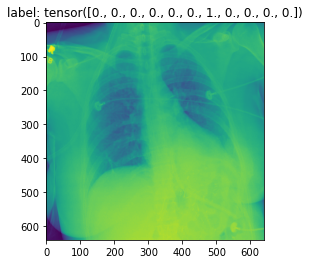

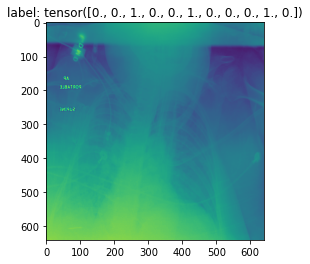

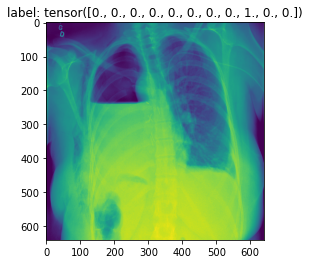

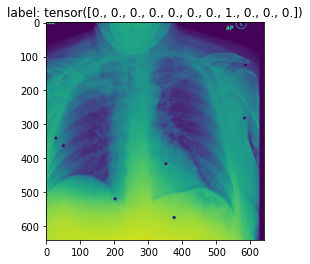

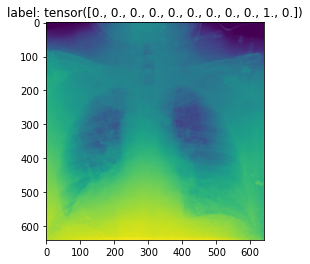

In [10]:
from matplotlib import pyplot as plt

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

## MODEL

In [11]:
class PAM_Module(nn.Module):
    """ Position attention module"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out


class CAM_Module(nn.Module):
    """ Channel attention module"""
    def __init__(self, in_dim):
        super(CAM_Module, self).__init__()
        self.chanel_in = in_dim
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = torch.softmax(energy_new, dim=-1)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out


class CBAM(nn.Module):
    def __init__(self, in_channels):
        # def __init__(self):
        super(CBAM, self).__init__()
        inter_channels = in_channels // 4
        self.conv1_c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU(inplace=True))
        
        self.conv1_s = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU(inplace=True))

        self.channel_gate = CAM_Module(inter_channels)
        self.spatial_gate = PAM_Module(inter_channels)

        self.conv2_c = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU(inplace=True))
        self.conv2_a = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU(inplace=True))

    def forward(self, x):
        feat1 = self.conv1_c(x)
        chnl_att = self.channel_gate(feat1)
        chnl_att = self.conv2_c(chnl_att)

        feat2 = self.conv1_s(x)
        spat_att = self.spatial_gate(feat2)
        spat_att = self.conv2_a(spat_att)

        x_out = chnl_att + spat_att

        return x_out

In [12]:
# ====================================================
# MODEL
# ====================================================
class CustomSeResNet152D(nn.Module):
    def __init__(self, model_name='seresnet152d_320', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        if pretrained:
            pretrained_path = '../input/resnet200d-pretrained-weight/resnet200d_ra2-bdba9bf9.pth'
            self.model.load_state_dict(torch.load(pretrained_path))
            print(f'load {model_name} pretrained model')
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, CFG.target_size)
        
    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return features, pooled_features, output
    
class CustomSeResNet152D_WLF(nn.Module):
    def __init__(self, model_name='seresnet152d_320', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        n_features  = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)
        if pretrained:
            pretrained_path = '../input/startingpointschestx/resnet200d_320_chestx.pth'
#             self.model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu'))['model'])
            
            checkpoint = torch.load(pretrained_path, map_location='cpu')['model']
            for key in list(checkpoint.keys()):
                if 'model.' in key:
                    checkpoint[key.replace('model.', '')] = checkpoint[key]
                    del checkpoint[key]
            self.model.load_state_dict(checkpoint) 
            
            print(f'load {model_name} pretrained model')
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Linear(n_features, CFG.target_size)
        
        self.local_fe = CBAM(n_features)
        self.classifier = nn.Sequential(nn.Linear(n_features + n_features, n_features), 
                                        nn.BatchNorm1d(n_features),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(n_features, CFG.target_size))
        
    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        
        global_features = self.pooling(features).view(bs, -1)
        
        local_features = self.local_fe(features)
        local_features = torch.sum(local_features, dim=[2, 3])  # ここ、どうしてsum？GAPではない？
        
        all_features = torch.cat([global_features, local_features], dim=1)
        output = self.classifier(all_features)
        
        return features, all_features, output

## Helper functions

In [13]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                _, _, y_preds = model(images)
                loss = criterion(y_preds, labels)
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1
                    
        elif CFG.device == 'TPU':
            _, _, y_preds = model(images)
            loss = criterion(y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      #'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       #lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
                                #'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
                                #lr=scheduler.get_lr()[0],
                                ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      .format(
                       step, len(valid_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(valid_loader)),
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                xm.master_print('EVAL: [{0}/{1}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                .format(
                                step, len(valid_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(valid_loader)),
                                ))
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

## Train loop

In [14]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    if CFG.device == 'GPU':
        LOGGER.info(f"========== fold: {fold} training ==========")
    elif CFG.device == 'TPU':
        if CFG.nprocs == 1:
            LOGGER.info(f"========== fold: {fold} training ==========")
        elif CFG.nprocs == 8:
            xm.master_print(f"========== fold: {fold} training ==========")
            
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='valid'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))
    
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, 
                                  batch_size=CFG.batch_size, 
                                  shuffle=True, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, 
                                  batch_size=CFG.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
        
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=CFG.batch_size,
                                                   sampler=train_sampler,
                                                   drop_last=True,
                                                   num_workers=CFG.num_workers)
        
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                   batch_size=CFG.batch_size * 2,
                                                   sampler=valid_sampler,
                                                   drop_last=False,
                                                   num_workers=CFG.num_workers)
        
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
    
    # ====================================================
    # model & optimizer
    # ====================================================
    if CFG.device == 'TPU':
        device = xm.xla_device()
    elif CFG.device == 'GPU':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = CustomSeResNet152D(CFG.model_name, pretrained=False)
    model.load_state_dict(torch.load(CFG.student, map_location=torch.device('cpu'))['model'])
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
            elif CFG.nprocs == 8:
                para_train_loader = pl.ParallelLoader(train_loader, [device])
                avg_loss = train_fn(para_train_loader.per_device_loader(device), model, criterion, optimizer, epoch, scheduler, device)
        elif CFG.device == 'GPU':
            avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # eval
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
            elif CFG.nprocs == 8:
                para_valid_loader = pl.ParallelLoader(valid_loader, [device])
                avg_val_loss, preds, valid_labels = valid_fn(para_valid_loader.per_device_loader(device), model, criterion, device)
                preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
                valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        elif CFG.device == 'GPU':
            avg_val_loss, preds, _ = valid_fn(valid_loader, model, criterion, device)
            
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
            
        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        
        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        elif CFG.device == 'TPU':
            if CFG.nprocs == 1:
                LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
            elif CFG.nprocs == 8:
                xm.master_print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                xm.master_print(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                xm.save({'model': model.state_dict(), 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
                
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                xm.save({'model': model.state_dict(), 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
        
        if CFG.nprocs != 8:
            check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            for c in [f'pred_{c}' for c in CFG.target_cols]:
                valid_folds[c] = np.nan
            valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [15]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
        
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                if CFG.nprocs != 8:
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [16]:
if __name__ == '__main__':
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========


Epoch: [1][0/3010] Data 1.809 (1.809) Elapsed 0m 4s (remain 223m 20s) Loss: 0.0937(0.0937) Grad: 37966.1406  
Epoch: [1][100/3010] Data 0.000 (0.018) Elapsed 1m 58s (remain 56m 49s) Loss: 0.0847(0.1131) Grad: 78918.6953  
Epoch: [1][200/3010] Data 0.000 (0.009) Elapsed 3m 52s (remain 54m 2s) Loss: 0.0537(0.1125) Grad: 29911.1602  
Epoch: [1][300/3010] Data 0.000 (0.006) Elapsed 5m 45s (remain 51m 53s) Loss: 0.2132(0.1154) Grad: 54473.1328  
Epoch: [1][400/3010] Data 0.000 (0.005) Elapsed 7m 39s (remain 49m 49s) Loss: 0.1250(0.1154) Grad: 49124.5312  
Epoch: [1][500/3010] Data 0.000 (0.004) Elapsed 9m 33s (remain 47m 51s) Loss: 0.0971(0.1139) Grad: 42465.7578  
Epoch: [1][600/3010] Data 0.000 (0.003) Elapsed 11m 27s (remain 45m 55s) Loss: 0.1288(0.1142) Grad: 45851.8516  
Epoch: [1][700/3010] Data 0.000 (0.003) Elapsed 13m 21s (remain 43m 58s) Loss: 0.1752(0.1143) Grad: 96014.6562  
Epoch: [1][800/3010] Data 0.000 (0.002) Elapsed 15m 14s (remain 42m 3s) Loss: 0.1751(0.1134) Grad: 53985.

Epoch 1 - avg_train_loss: 0.1169  avg_val_loss: 0.1039  time: 3747s
Epoch 1 - Score: 0.9718  Scores: [0.9836 0.9782 0.9952 0.98   0.9784 0.9882 0.9913 0.9447 0.9075 0.9424
 0.9999]
Epoch 1 - Save Best Score: 0.9718 Model


EVAL: [375/376] Data 0.000 (0.226) Elapsed 5m 22s (remain 0m 0s) Loss: 0.0108(0.1039) 


Epoch 1 - Save Best Loss: 0.1039 Model


Epoch: [2][0/3010] Data 1.751 (1.751) Elapsed 0m 3s (remain 163m 10s) Loss: 0.0453(0.0453) Grad: 20753.1602  
Epoch: [2][100/3010] Data 0.000 (0.018) Elapsed 1m 57s (remain 56m 10s) Loss: 0.2233(0.1234) Grad: 77698.0547  
Epoch: [2][200/3010] Data 0.000 (0.009) Elapsed 3m 50s (remain 53m 45s) Loss: 0.1404(0.1185) Grad: 57464.2305  
Epoch: [2][300/3010] Data 0.000 (0.006) Elapsed 5m 44s (remain 51m 37s) Loss: 0.0855(0.1173) Grad: 49540.3125  
Epoch: [2][400/3010] Data 0.000 (0.005) Elapsed 7m 37s (remain 49m 36s) Loss: 0.0912(0.1180) Grad: 34438.4219  
Epoch: [2][500/3010] Data 0.000 (0.004) Elapsed 9m 30s (remain 47m 38s) Loss: 0.0620(0.1161) Grad: 16435.3516  
Epoch: [2][600/3010] Data 0.000 (0.003) Elapsed 11m 24s (remain 45m 44s) Loss: 0.1048(0.1161) Grad: 22194.9160  
Epoch: [2][700/3010] Data 0.000 (0.003) Elapsed 13m 18s (remain 43m 49s) Loss: 0.1597(0.1157) Grad: 34617.0859  
Epoch: [2][800/3010] Data 0.000 (0.002) Elapsed 15m 11s (remain 41m 53s) Loss: 0.0937(0.1158) Grad: 1794

Epoch 2 - avg_train_loss: 0.1147  avg_val_loss: 0.1038  time: 3737s
Epoch 2 - Score: 0.9719  Scores: [0.9828 0.9785 0.9951 0.98   0.9782 0.9882 0.9915 0.9457 0.9085 0.9431
 0.9999]
Epoch 2 - Save Best Score: 0.9719 Model


EVAL: [375/376] Data 0.000 (0.215) Elapsed 5m 18s (remain 0m 0s) Loss: 0.0099(0.1038) 


Epoch 2 - Save Best Loss: 0.1038 Model
========== fold: 0 result ==========
Score: 0.9719  Scores: [0.9828 0.9785 0.9951 0.98   0.9782 0.9882 0.9915 0.9457 0.9085 0.9431
 0.9999]
========== CV ==========
Score: 0.9719  Scores: [0.9828 0.9785 0.9951 0.98   0.9782 0.9882 0.9915 0.9457 0.9085 0.9431
 0.9999]
